In [10]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import wrangle

In [32]:
red = wrangle.wrangle_data('red')
white = wrangle.wrangle_data('white')
df = wrangle.wrangle_data('both')

from helpers.prep import train_test_validate_split as split

red, _, _ = split(red)
white, _, _, = split(white)
df, _, _, = split(df)

In this notebook I attempt to determine which outliers should potentially be dropped.  Red wines and white wines are different worlds so the problem needs to be considered for each type of wine seperately.

In [33]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type
434,10.4,0.41,0.55,3.2,0.076,22.0,54.0,0.99960,3.15,0.89,9.9,6,red
3936,6.5,0.28,0.35,9.8,0.067,61.0,180.0,0.99720,3.15,0.57,9.0,4,white
3914,7.7,0.42,0.38,8.1,0.061,49.0,144.0,0.99660,3.40,0.58,11.0,6,white
5272,5.4,0.30,0.30,1.2,0.029,25.0,93.0,0.98742,3.31,0.40,13.6,7,white
3687,8.7,0.15,0.30,1.6,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,6,white


In [34]:
import helpers.outliers

# Red wines

The features that seem the most useful to handle outliers on red are as follows:

- residual_sugar
- chlorides
- total_sulfur_dioxide
- sulphates

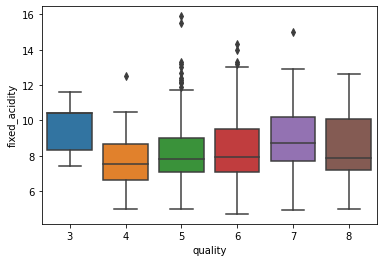

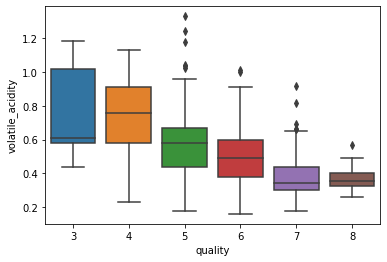

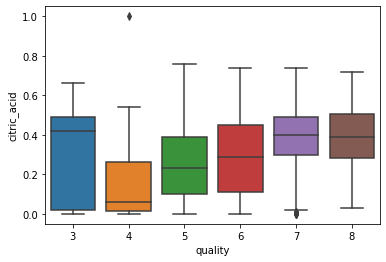

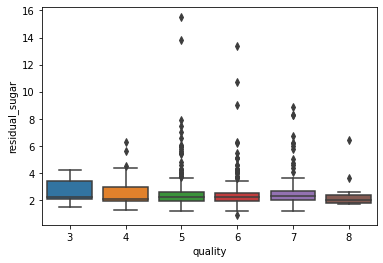

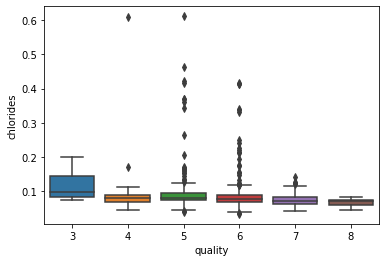

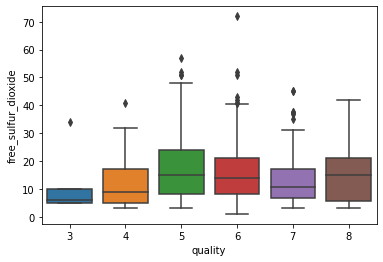

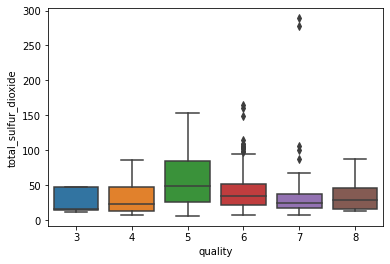

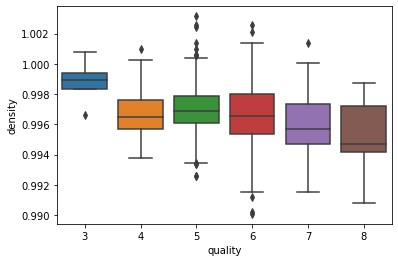

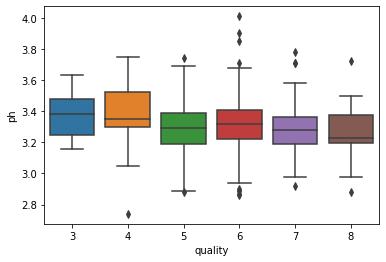

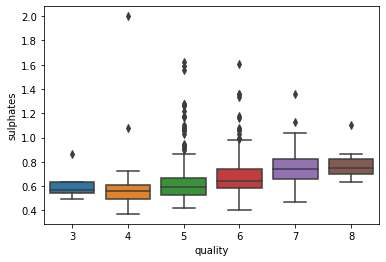

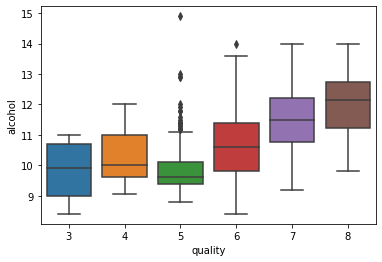

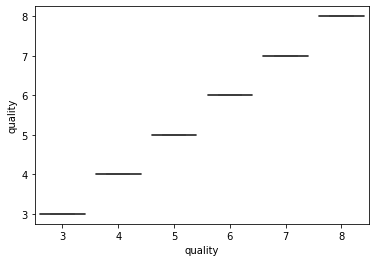

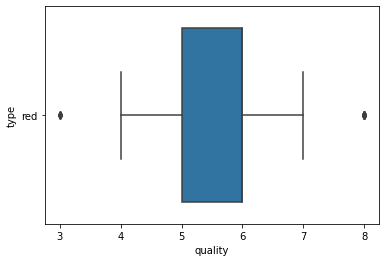

In [37]:
for col in red:
    sns.boxplot(data=red, y=col, x='quality')
    plt.show()

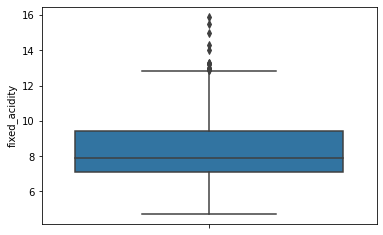

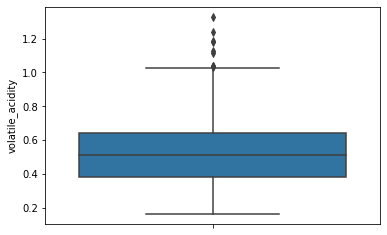

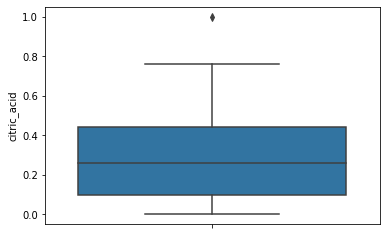

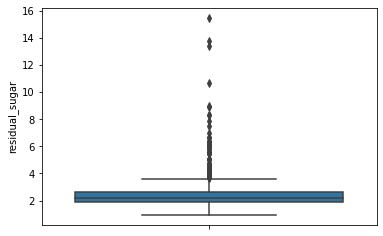

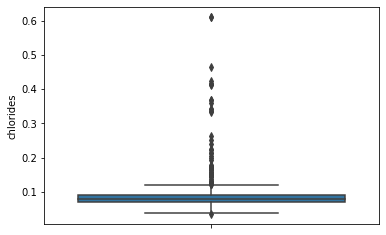

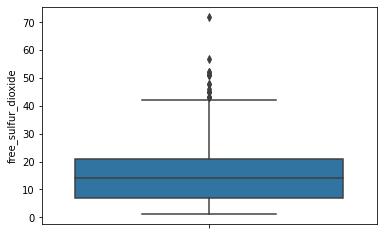

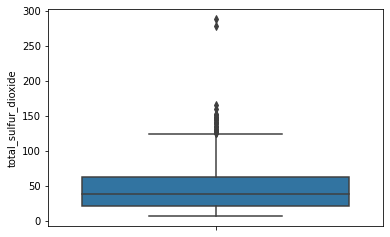

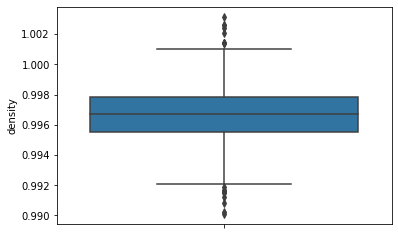

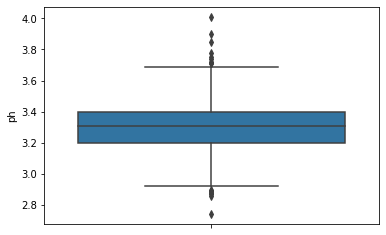

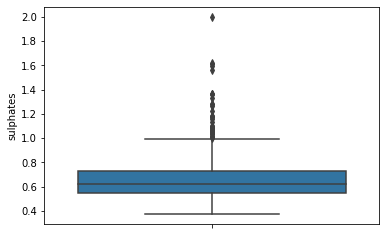

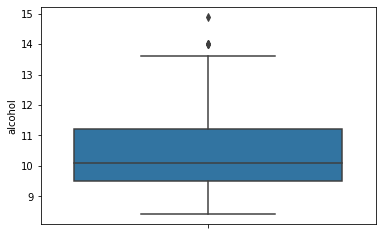

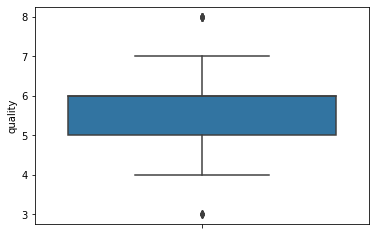

In [38]:
for col in red.select_dtypes('number'):
    sns.boxplot(data=red, y=col)
    plt.show()

# White wines

In [41]:
white.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type
1327,6.8,0.26,0.33,1.5,0.047,44.0,167.0,0.99280,3.12,0.44,10.5,6,white
622,5.3,0.32,0.12,6.6,0.043,22.0,141.0,0.99370,3.36,0.60,10.4,6,white
4737,6.1,0.24,0.32,9.0,0.031,41.0,134.0,0.99234,3.25,0.26,12.3,7,white
3503,6.9,0.33,0.31,4.2,0.040,21.0,93.0,0.98960,3.18,0.48,13.4,7,white
4239,5.7,0.28,0.36,1.8,0.041,38.0,90.0,0.99002,3.27,0.98,11.9,7,white


The features that seem the most useful to handle outliers on white are as follows:

- citric_acid
- residual_sugar
- chlorides
- free_sulfur_dioxide
- total_sulfur_dioxide
- density
- sulphates

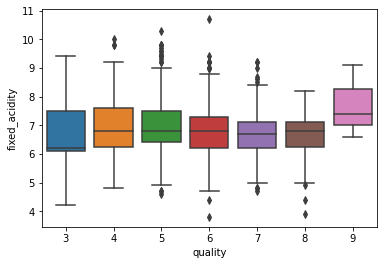

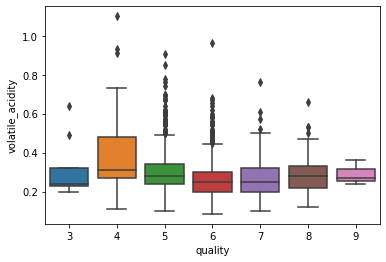

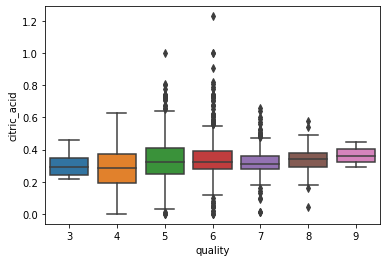

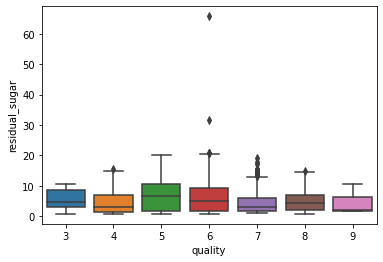

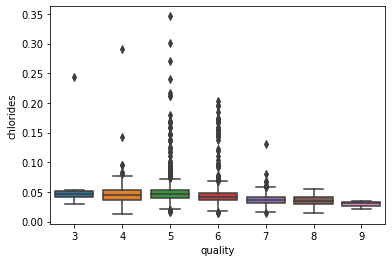

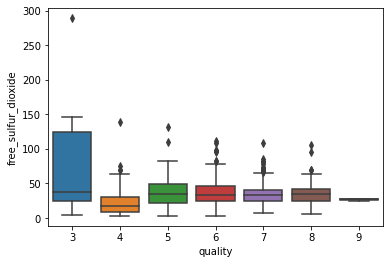

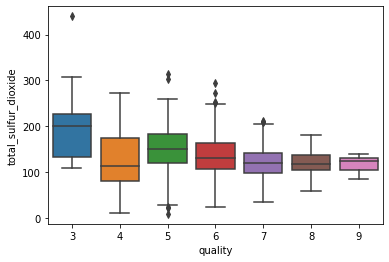

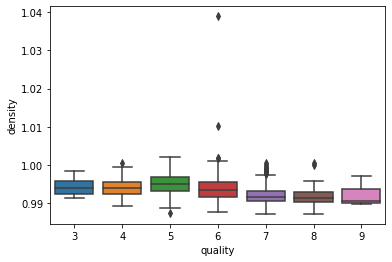

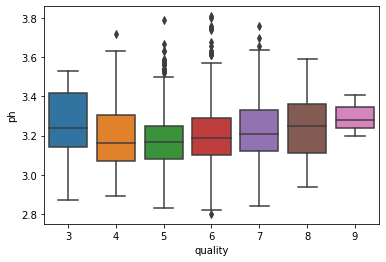

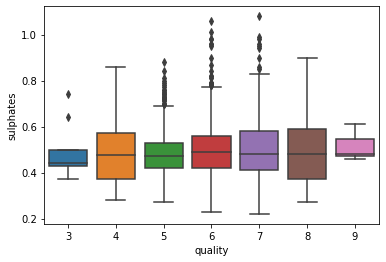

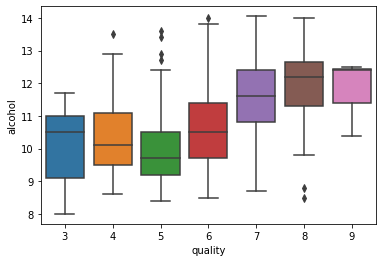

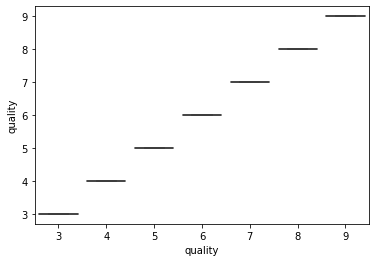

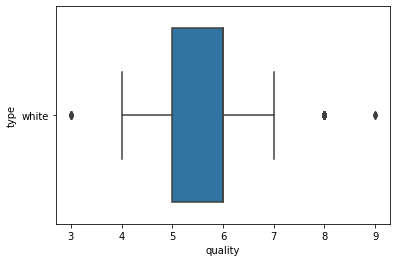

In [40]:
for col in white:
    sns.boxplot(data=white, y=col, x='quality')
    plt.show()

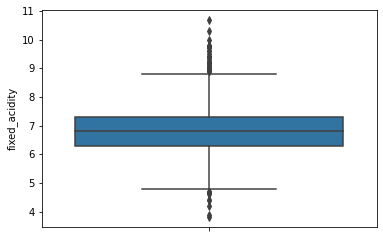

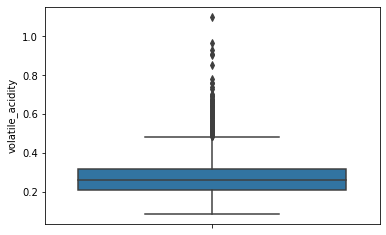

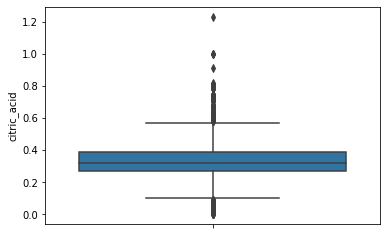

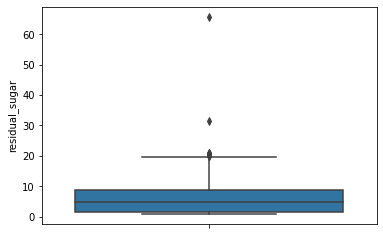

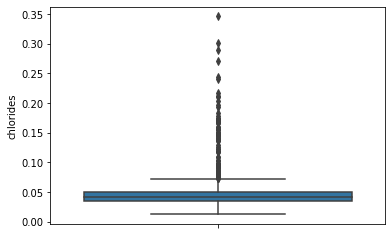

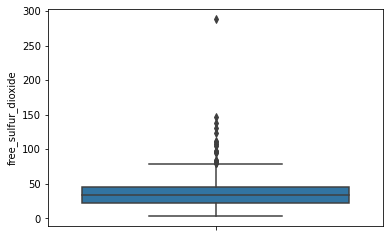

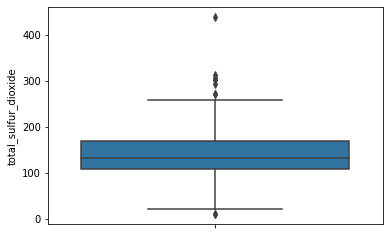

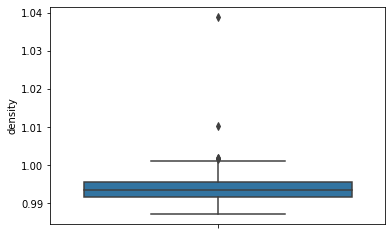

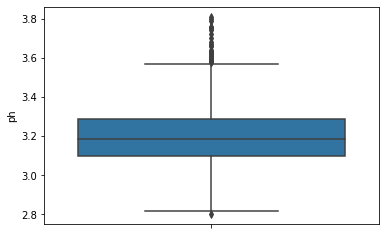

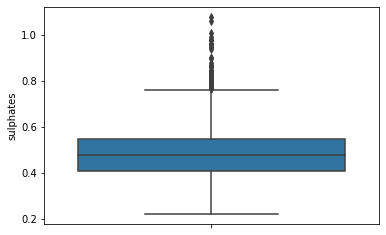

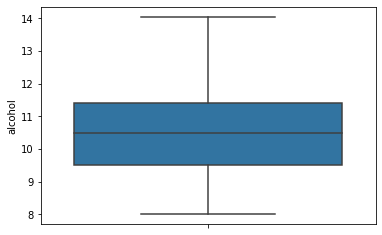

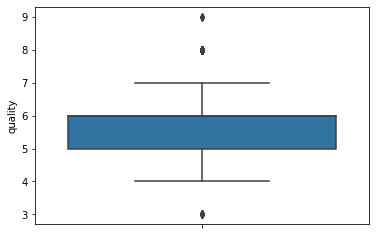

In [39]:
for col in white.select_dtypes('number'):
    sns.boxplot(data=white, y=col)
    plt.show()

# Outlier handler

In [46]:
white.density.describe()

count    2376.000000
mean        0.993750
std         0.002966
min         0.987110
25%         0.991578
50%         0.993400
75%         0.995625
max         1.038980
Name: density, dtype: float64

In [49]:
def drop_outliers(df, dataset, method='iqr', **kwargs):
    '''Given a wine dataset, handle the outliers according to the specified method.

    By default a list of columns to manipulate is generated by the dataset parameter. This can be overriden by passing a list of column names in the cols parameter.

    Parameters
    ----------
    dataset : str
        Defines which type of wine the function is removing outlies for.  Must be either 'red' or 'white'.
    method : str
        Determines how outliers are identified
        "iqr" : Uses the 1.5 IQR method
        "manual" : Uses pre-defined and hard-coded cutoff limits for each column.
    '''

    default_cols = {
        'white' : [ 
            'citric_acid',
            'residual_sugar',
            'chlorides',
            'free_sulfur_dioxide',
            'total_sulfur_dioxide',
            'density',
            'sulphates',
        ],
        'red' : [
            'residual_sugar',
            'chlorides',
            'total_sulfur_dioxide',
            'sulphates',
        ]
    }

    defaultKwargs = {
        'cols': default_cols[dataset],
        'k' : 1.5
    }
    kwargs = { **defaultKwargs, **kwargs }

    if method == 'manual':
        manual_outlier_bounds = {
            'white': {
                # Determined by Luis's research
                'citric_acid'           : 1.25,
                'residual_sugar'        : 26,
                'chlorides'             : .250, 
                'volatile_acidity'      : 690,
                'free_sulfur_dioxide'   : 200,
                'total_sulfur_dioxide'  : 200,
                'density'               : 1,
                'sulphates'             : .900,
            },
            'red': {
                'fixed_acidity'         : 14,
                'volatile_acidity'      : 1,
                'citric_acid'           : .8,
                'residual_sugar'        : 8,
                'chlorides'             : .2,
                'total_sulfur_dioxide'  : 130,
                'free_sulfur_dioxide'   : 50,
                'density'               : 1.001,
                'ph'                    : 3.75,
                'sulphates'             : 1.25,
                'alcohol'               : 14,
            }
        }
        bounds = manual_outlier_bounds[dataset]

        for col in kwargs['cols']:
            if col not in bounds:
                raise Exception(f'"{col}" does not have a manual cutoff value defined. Use IQR method instead.')
            df = df[df[col] <= bounds[col]]
    
    elif method == 'iqr':
        from helpers.outliers import drop_upper_outliers
        df = drop_upper_outliers(df, kwargs['cols'], kwargs['k'])

    else: raise Exception('Invalid method supplied. Use "manual" or "iqr".')

    return df

In [50]:
red_bak = red.copy()
white_bak = white.copy()

In [51]:
red_bak.shape, white_bak.shape

((815, 13), (2376, 13))

In [53]:
drop_outliers(red, 'red', 'manual').shape

(764, 13)

In [57]:
drop_outliers(red, 'red', 'iqr').shape

(654, 13)

In [59]:
drop_outliers(white, 'white', 'manual').shape


(2148, 13)

In [60]:
drop_outliers(white, 'white', 'iqr').shape

(2107, 13)

In [61]:
drop_outliers(white, 'white', 'iqr', cols=['density']).shape

(2371, 13)